# Try running the old CMILOS on the stokes file from HRT to see if really one big difference

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import subprocess

In [2]:
def run_cmilos(data,wave_axis,rte,OLD_CMILOS_LOC, options=[6,15],out_dir='./', synthesis=0):
    """RTE inversion using CMILOS

    Parameters
    ----------
    data: numpy ndarray
        Stokes profiles [y,x,stokes,wavelength] in the order IQUV
    wave_axis: numpy ndarray
        wavelength axis of the data in Angstrom
    rte: str
        RTE or CE or CE+RTE
    options: list
        options for CMILOS [num_wavelength_points, num_iterations] (default num_iterations = 15)
    out_dir: str
        output directory for intermediate .txt files
    loc: str
        location of the CMILOS executable

    Returns
    -------
    result: numpy ndarray
        inverted physical quantities [y,x,12] 
    """
    try:
        if os.path.isfile(OLD_CMILOS_LOC+'milos'):
            pass #print("Cmilos executable located at:", CMILOS_LOC)
        else:
            raise ValueError('Cannot find cmilos:', OLD_CMILOS_LOC)

    except ValueError as err:
        print(err.args[0])
        print(err.args[1])
        return        

    if data.ndim == 4:
        sdata = data
    elif data.ndim != 4:
        print("Incorrect dimensions of 'data' array")
        exit()
    y,x,_,l = sdata.shape
    filename = out_dir + 'dummy_in.txt'
    with open(filename,"w") as f:
        for i in range(x):
            for j in range(y):
                for k in range(l):
                    f.write('%e %e %e %e %e \n' % (wave_axis[k],sdata[j,i,0,k],sdata[j,i,1,k],sdata[j,i,2,k],sdata[j,i,3,k])) #wv, I, Q, U, V

    cmd = OLD_CMILOS_LOC+"./milos"

    if rte == 'RTE':
        _ = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 0 {synthesis} {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)
    if rte == 'CE':
        _ = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 2 {synthesis} {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)
    if rte == 'CE+RTE':
        _ = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 1 {synthesis} {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)

    _ = subprocess.call(f"rm {out_dir + 'dummy_in.txt'}",shell=True)

    res = np.loadtxt(out_dir+'dummy_out.txt')
    _ = subprocess.call(f"rm {out_dir+'dummy_out.txt'}",shell=True)
    return res
    # if synthesis==0:
    #     result = np.zeros((12,y*x)).astype(float)
    #     for i in range(y*x):
    #         result[:,i] = res[i*12:(i+1)*12]
    #     result = result.reshape(12,x,y)
    #     result = np.einsum('ijk->ikj', result)
    #     return result
    
    # elif synthesis==1:
    #     return res

In [3]:
def fits_get_sampling(file,num_wl = 6,verbose = False):
    '''
    wave_axis,voltagesData,tunning_constant,cpos = fits_get_sampling(file)
    No S/C velocity corrected!!!
    cpos = 0 if continuum is at first wavelength and = num_wl - 1 (usually 5) if continuum is at the end
    '''
    fg_head = 3

    with fits.open(file) as hdu_list:
        header = hdu_list[fg_head].data
        tunning_constant = float(header[0][4])/1e9
        ref_wavelength = float(header[0][5])/1e3
        
        voltagesData = np.zeros(num_wl)
        hi = np.histogram(header['PHI_FG_voltage'],bins=7)
        yi = hi[0]; xi = hi[1]
        j = 0
        try:
            for i in range(num_wl + 1):
                if yi[i] != 0 :
                    if i < num_wl:
                        idx = np.logical_and(header['PHI_FG_voltage']>=xi[i],header['PHI_FG_voltage']<xi[i+1])
                    else:
                        idx = np.logical_and(header['PHI_FG_voltage']>=xi[i],header['PHI_FG_voltage']<=xi[i+1])
                    voltagesData[j] = int(np.median(header['PHI_FG_voltage'][idx]))
                    j += 1
        except:
            printc('WARNING: Running fits_get_sampling_SPG',color=bcolors.WARNING)
            return fits_get_sampling_SPG(file, False)
    
    d1 = voltagesData[0] - voltagesData[1]
    d2 = voltagesData[num_wl-2] - voltagesData[num_wl-1]
    if np.abs(d1) > np.abs(d2):
        cpos = 0
    else:
        cpos = num_wl-1
    if verbose:
        print('Continuum position at wave: ', cpos)
    wave_axis = voltagesData*tunning_constant + ref_wavelength  #6173.3356
    #print(wave_axis)
    return wave_axis,voltagesData,tunning_constant,cpos

In [11]:
bmag_1 = fits.getdata('/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-bmag_20231012T001503_V202408291137_0350120601.fits.gz')

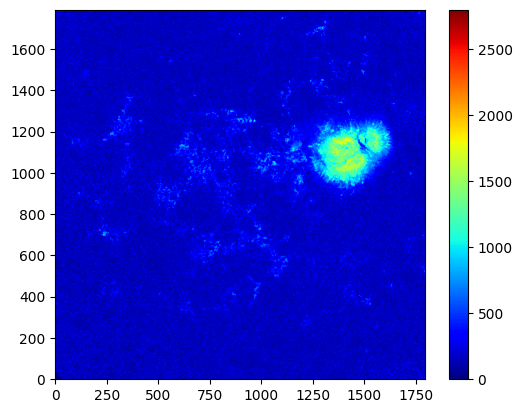

In [4]:
plt.imshow(bmag_1,cmap='jet',vmin=0,vmax=2800,origin="lower")
plt.colorbar()
plt.show()

In [4]:
stokes_1 = fits.getdata('/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-stokes_20231012T001503_V202408291137_0350120601.fits.gz')

In [5]:
stokes_1.shape

(6, 4, 1792, 1792)

In [6]:
shdu = fits.open('/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-stokes_20231012T001503_V202408291137_0350120601.fits.gz')

In [7]:
wave_axis,voltagesData,tunning_constant,cpos = fits_get_sampling('/data/solo/phi/data/fmdb/public/l2/2023-10-12/solo_L2_phi-hrt-stokes_20231012T001503_V202408291137_0350120601.fits.gz')

In [8]:
wave_axis

array([6173.1386512, 6173.2974388, 6173.3645371, 6173.4344458,
       6173.5040032, 6173.5735606])

In [9]:
stokes_1_moved = np.swapaxes(stokes_1,0,2)
stokes_1_moved = np.swapaxes(stokes_1_moved,1,3)
stokes_1_moved = np.swapaxes(stokes_1_moved,2,3)

In [15]:
stokes_1_moved.shape

(1792, 1792, 4, 6)

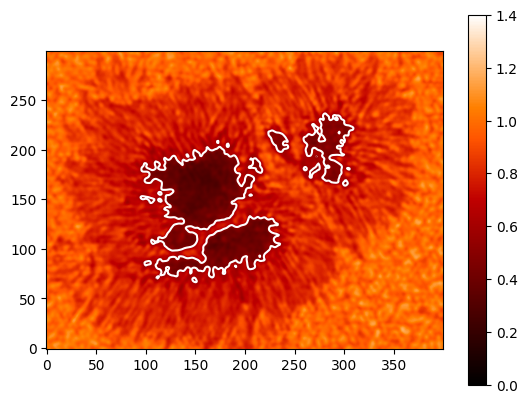

In [76]:
plt.figure()
im=plt.imshow(stokes_1_moved[950:1250,1250:1650,0,0],cmap='gist_heat',vmin=0,vmax=1.4,origin="lower")
CS=plt.contour(stokes_1_moved[950:1250,1250:1650,0,0],levels=[0.55],colors='white')
plt.colorbar(im)
plt.show()

In [80]:
stokes_1.shape

(6, 4, 1792, 1792)

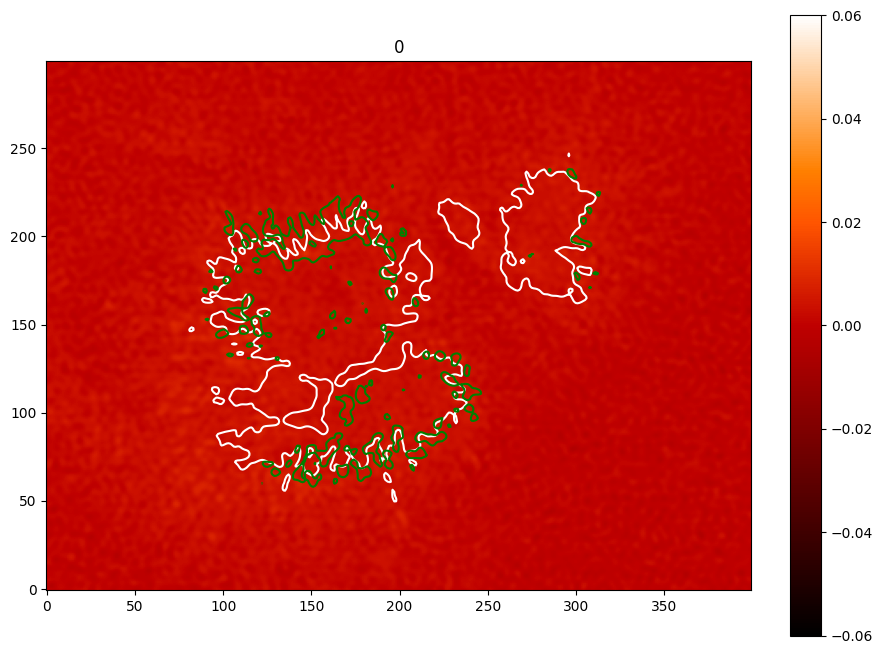

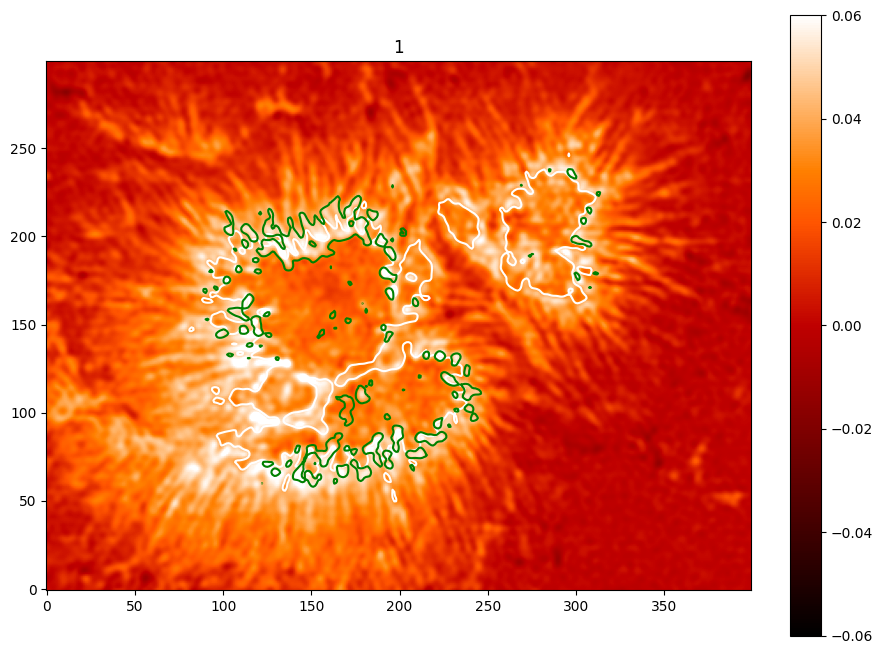

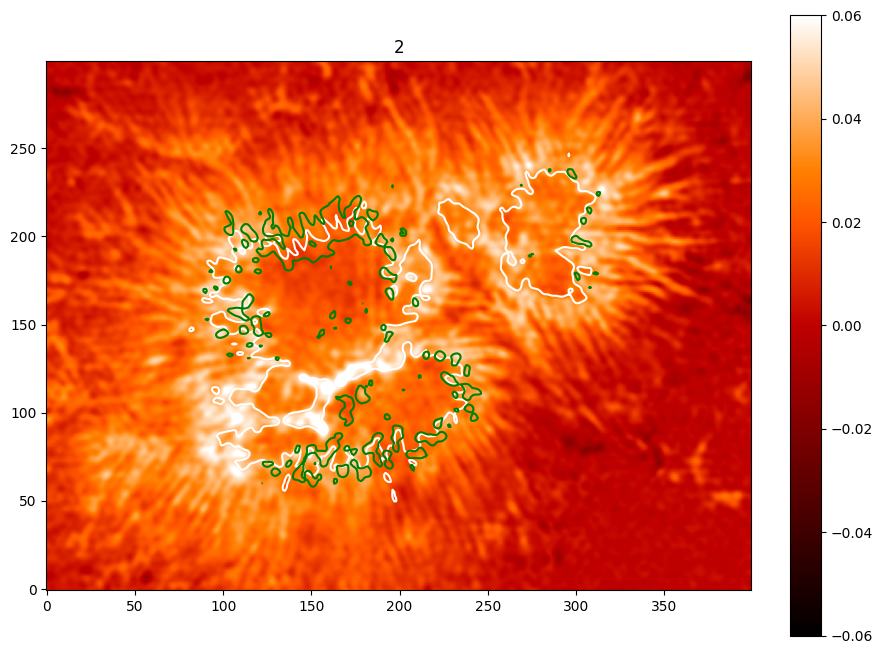

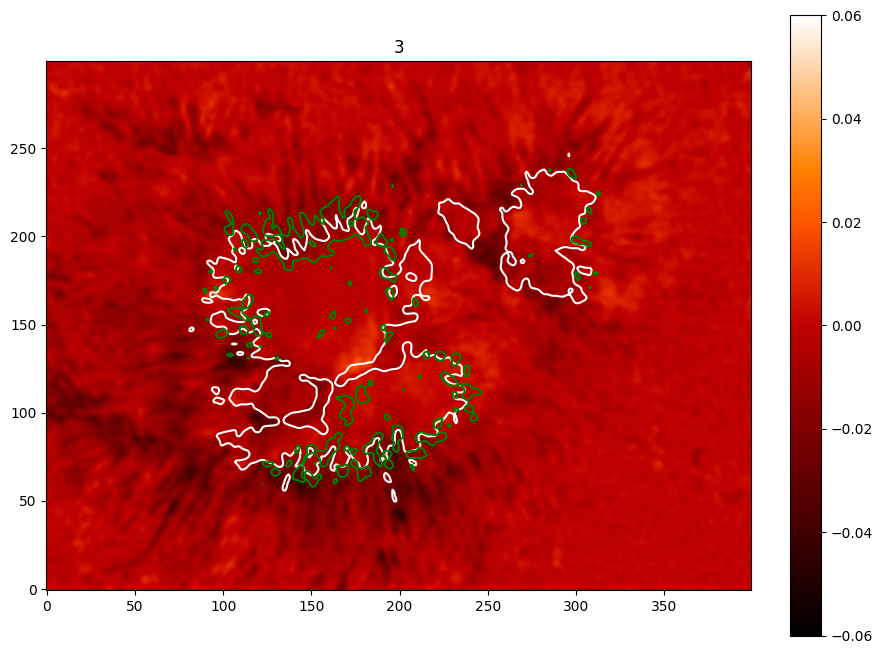

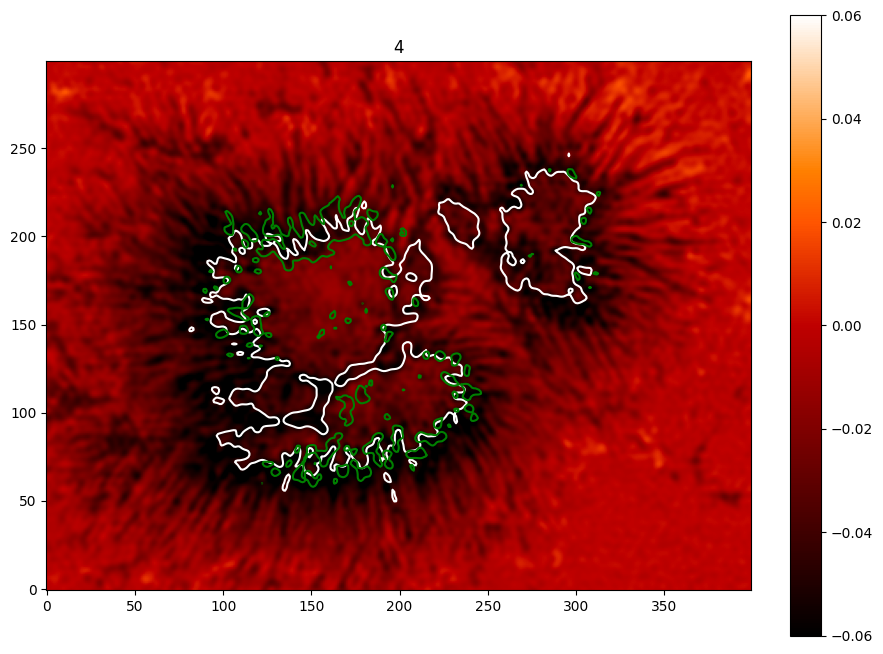

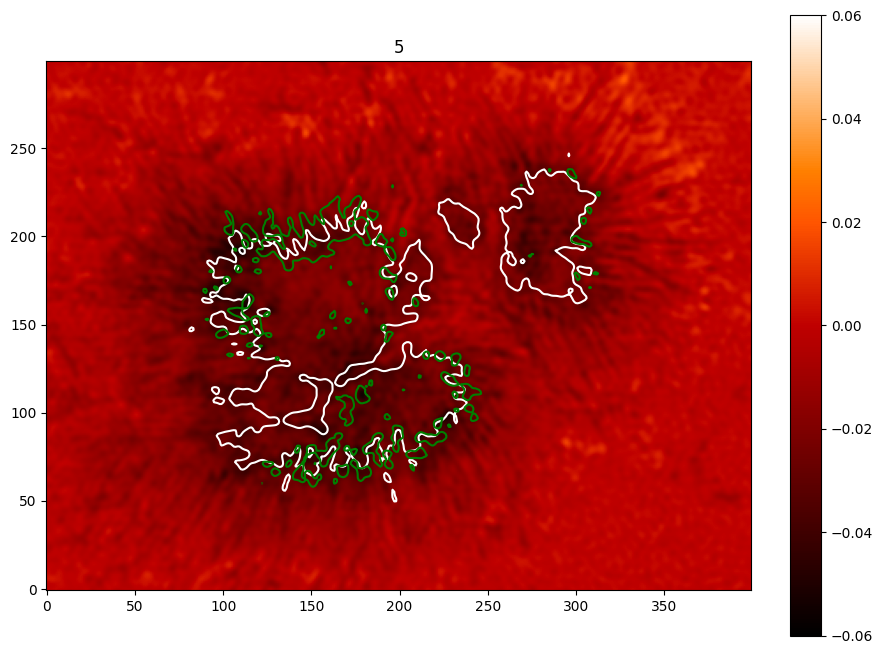

In [89]:
for i in range(6):
    plt.figure(figsize=(10,10))
    im=plt.imshow(stokes_1_moved[950:1250,1250:1650,3,i],cmap='gist_heat',vmin=-0.06,vmax=0.06,origin="lower")
    CS=plt.contour(stokes_1_moved[950:1250,1250:1650,0,5],levels=[0.55],colors='white')
    CS=plt.contour(bmag_1[950:1250,1250:1650],levels=[1600],colors='green')
    plt.title(i)
    plt.colorbar(im,fraction=0.04)
    plt.show()

In [95]:
#umbral_idx = np.where(stokes_1_moved[900:1300,1200:1700,0,0]<0.55)
umbral_idx = np.where(bmag_1[900:1300,1200:1700]>1500)

In [93]:
umbral_idx[1].shape

(11357,)

In [96]:
umbra_pix=stokes_1_moved[900:1300,1200:1700,:,:][umbral_idx[0],umbral_idx[1],:,:].mean(axis=(0))
umbra_std=stokes_1_moved[900:1300,1200:1700,:,:][umbral_idx[0],umbral_idx[1],:,:].std(axis=(0))

In [44]:
umbra_pix.shape

(4, 6)

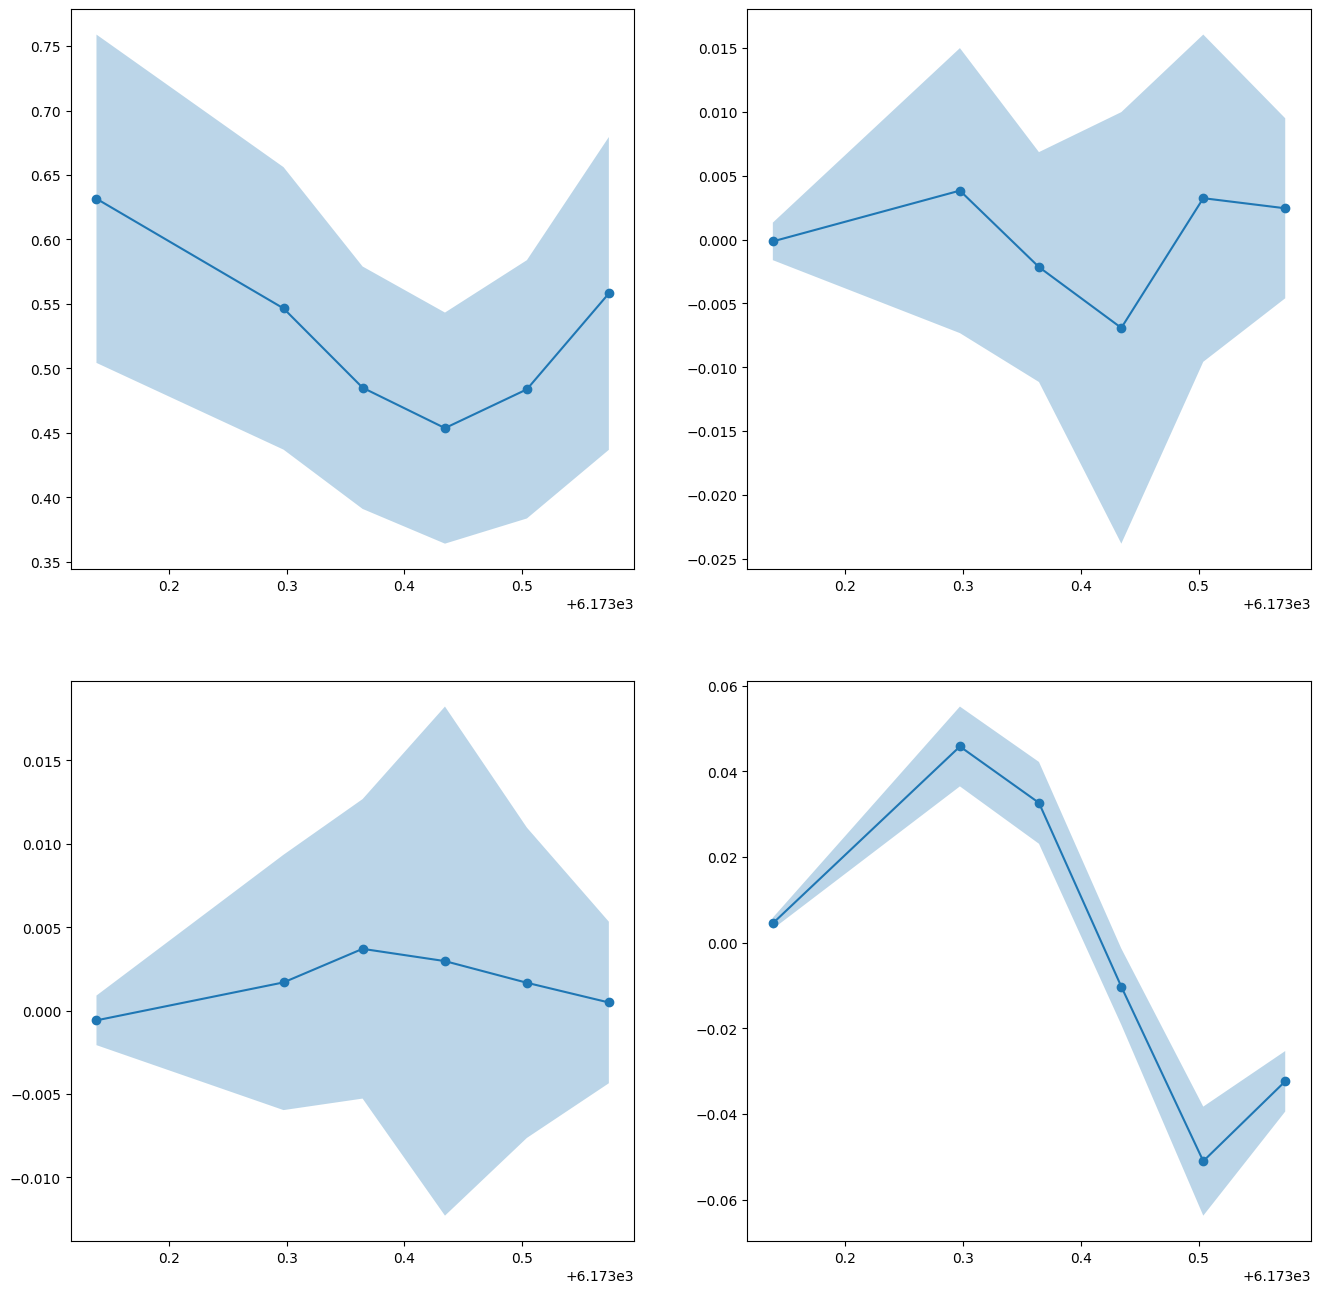

In [97]:
stokesi = 0
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
stokesi = 1
plt.subplot(222)
plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
stokesi = 2
plt.subplot(223)
plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
stokesi = 3
plt.subplot(224)
plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
plt.show()

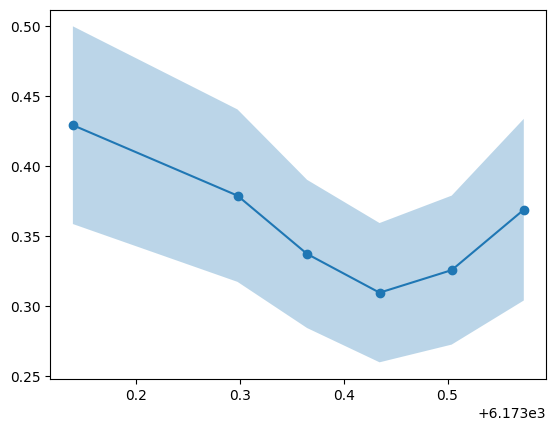

In [54]:
stokesi = 0

plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
plt.show()

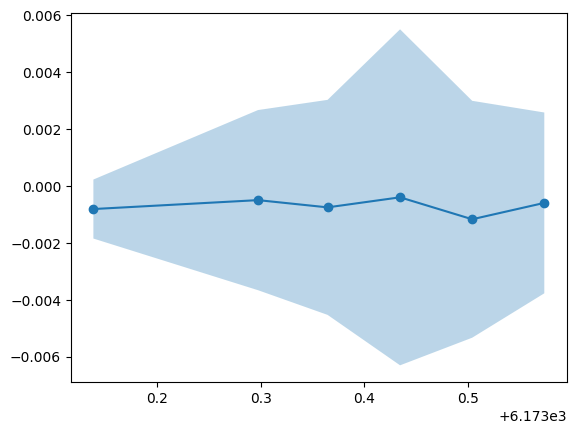

In [57]:
stokesi = 1

plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
plt.show()

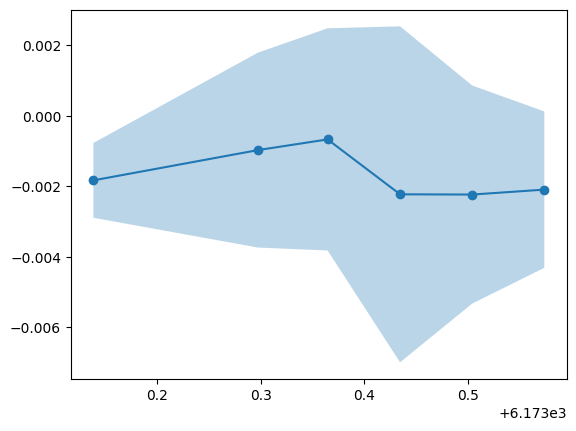

In [56]:
stokesi = 2

plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
plt.show()

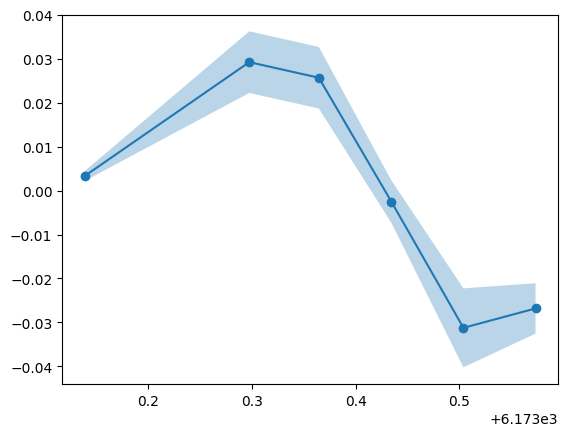

In [55]:
stokesi = 3

plt.plot(wave_axis,umbra_pix[stokesi,:],marker='o')
plt.fill_between(wave_axis,umbra_pix[stokesi,:]-umbra_std[stokesi,:],umbra_pix[stokesi,:]+umbra_std[stokesi,:],alpha=0.3)
plt.show()

In [67]:
OLD_CMILOS_LOC='/scratch/slam/sinjan/solo_attic_fits/hrt_pipeline/cmilos_100555/'#'/scratch/slam/sinjan/solo_attic_fits/hrt_pipeline/cmilos/'

result_new = run_cmilos(stokes_1_moved[800:1300,1200:1700,:,:],wave_axis[:],'CE+RTE',OLD_CMILOS_LOC, options=[6,20],out_dir='./', synthesis=0)

In [68]:
result_new.shape

(3000000,)

In [69]:
y=500
x=500

In [70]:
result1 = np.zeros((12,y*x)).astype(float)
rte_invs = np.zeros((12,y,x)).astype(float)
for i in range(y*x):
    result1[:,i] = result_new[i*12:(i+1)*12]
result1 = result1.reshape(12,x,y)
result1 = np.einsum('ijk->ikj', result1)

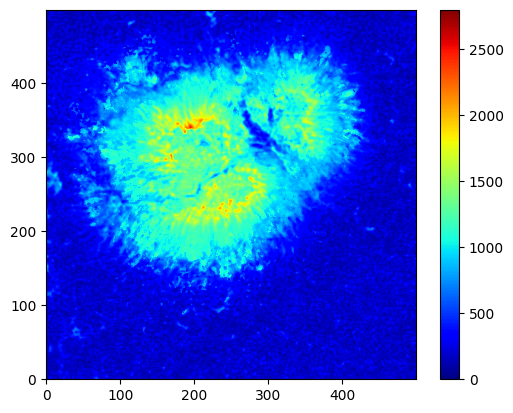

In [71]:
plt.imshow(result1[2,:,:],cmap='jet',vmin=0,vmax=2800,origin="lower")
plt.colorbar()
plt.show()

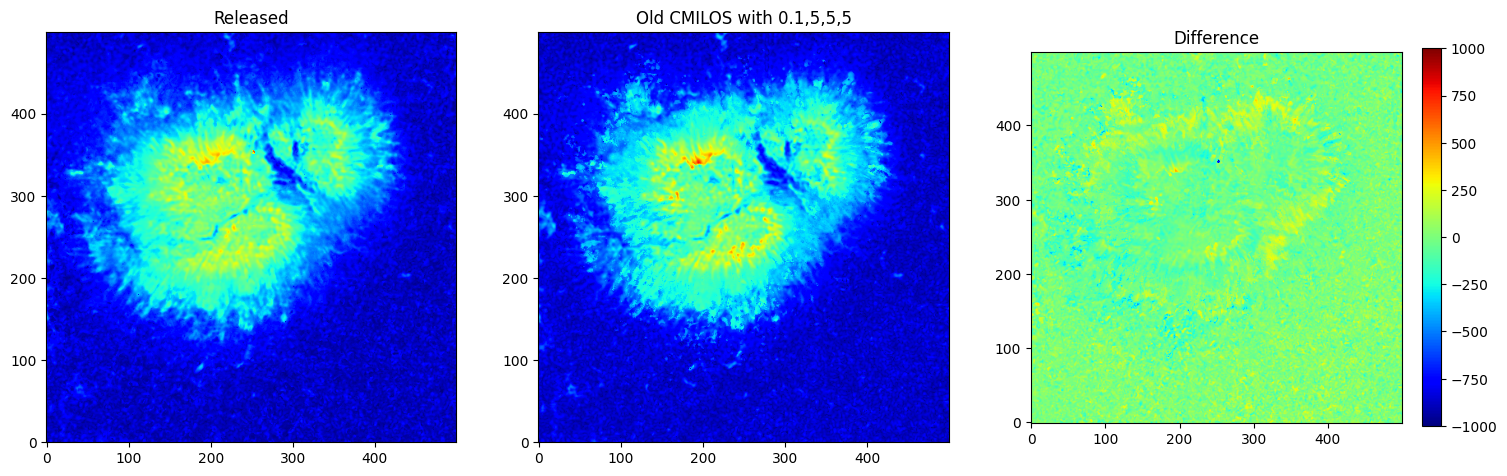

In [72]:
plt.figure(figsize=(18,8))
plt.subplot(131)
plt.imshow(bmag_1[800:1300,1200:1700],cmap='jet',vmin=0,vmax=2800,origin="lower")
#plt.colorbar()
plt.title('Released')

plt.subplot(132)
plt.imshow(result1[2,:,:],cmap='jet',vmin=0,vmax=2800,origin="lower")
#plt.colorbar()
plt.title('Old CMILOS with 0.1,5,5,5')

plt.subplot(133)
plt.imshow(result1[2,:,:]-bmag_1[800:1300,1200:1700],cmap='jet',vmin=-1000,vmax=1000,origin="lower")
plt.colorbar(fraction=0.046)
plt.title('Difference')
plt.show()

In [72]:
diff = result1[2,:,:]-bmag_1[800:1300,1200:1700]

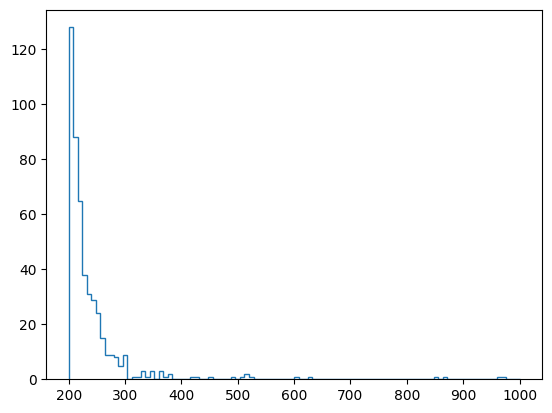

In [73]:
plt.hist(diff.flatten(),histtype='step',bins=100,range=(200,1000))
plt.show()